In [337]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, RandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [338]:
df = pd.read_csv("train.csv")
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,label
0,0,0.165202,-0.478520,-2.257107,-0.553981,1.765257,1.299021,-0.046894,0.666681,0.680690,-1.671282,-0.153746,-0.195847,-0.220067,2.566026,-1.570657,2
1,1,-0.224334,-0.767142,-0.240347,-0.051352,0.305125,-1.721982,-2.465773,-1.101852,0.897459,-1.206320,0.729931,0.403281,-0.005451,-1.395800,-1.634428,0
2,2,0.089218,0.399756,0.947436,0.319036,0.688324,1.496136,0.191788,0.007435,0.163002,-1.375127,0.187362,-0.016887,0.766921,-1.150965,0.379291,4
3,3,-0.195872,0.507818,-1.799445,-1.169515,-0.923603,0.183832,-0.424816,0.592742,-0.075206,-0.845360,-0.927943,-0.328885,-0.701013,-0.630973,0.405728,1
4,4,-0.243670,0.079381,-0.780691,-2.072413,-1.380842,-0.140338,0.497398,-1.527575,-0.034950,-1.539090,-0.581833,0.441491,-0.140839,0.120535,0.105580,2


In [339]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1125 non-null   int64  
 1   0           1125 non-null   float64
 2   1           1125 non-null   float64
 3   2           1125 non-null   float64
 4   3           1125 non-null   float64
 5   4           1125 non-null   float64
 6   5           1125 non-null   float64
 7   6           1125 non-null   float64
 8   7           1125 non-null   float64
 9   8           1125 non-null   float64
 10  9           1125 non-null   float64
 11  10          1125 non-null   float64
 12  11          1125 non-null   float64
 13  12          1125 non-null   float64
 14  13          1125 non-null   float64
 15  14          1125 non-null   float64
 16  label       1125 non-null   int64  
dtypes: float64(15), int64(2)
memory usage: 149.5 KB


<AxesSubplot:xlabel='label', ylabel='count'>

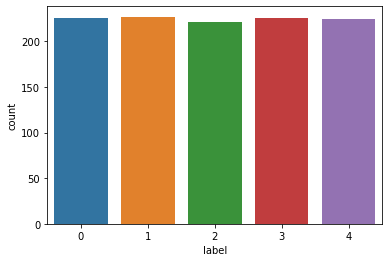

In [340]:
sns.countplot(x = 'label', data=df)

In [341]:
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]

In [342]:
# # Split into train+val and test
# X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# # Split train into train-val
# X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [343]:
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=21)

In [377]:
df_test = pd.read_csv("test1.csv")
Xt = df_test.iloc[:, 1:]

In [384]:
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test = np.array(Xt)

In [393]:
class ClassifierDataset(Dataset):
    
    def __init__(self, data, mode='train'):
        self.mode = mode
        if self.mode!='test':
            X_data, y_data = data
            self.X_data = X_data
            self.y_data = y_data
        else:
            self.X_data = data
        
    def __getitem__(self, index):
        if self.mode=='test':
            return self.X_data[index]
        else:
            return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset([torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long()])
val_dataset = ClassifierDataset([torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long()])
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), mode='test')

In [394]:
def get_class_distribution(obj):
    count_dict = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0
    }
    
    for i in obj:
        if i == 0: 
            count_dict[0] += 1
        elif i == 1: 
            count_dict[1] += 1
        elif i == 2: 
            count_dict[2] += 1
        elif i == 3: 
            count_dict[3] += 1
        elif i == 4: 
            count_dict[4] += 1  
        elif i == 5: 
            count_dict[5] += 1              
        else:
            print("Check classes.")
            
    return count_dict
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
class_weights_all = class_weights[target_list]

sampler = WeightedRandomSampler(
    weights=[1,1,1,1,1],
    num_samples=len(class_weights_all),
    replacement=True
)

In [395]:
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 5

In [396]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
#                           sampler=sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [397]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 9)
#         self.layer_2 = nn.Linear(12, 9)
#         self.layer_3 = nn.Linear(9, 6)
        self.layer_out = nn.Linear(9, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(9)
#         self.batchnorm2 = nn.BatchNorm1d(9)
#         self.batchnorm3 = nn.BatchNorm1d(6)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
#         x = self.layer_2(x)
#         x = self.batchnorm2(x)
#         x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.layer_3(x)
#         x = self.batchnorm3(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [398]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [399]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=15, out_features=9, bias=True)
  (layer_out): Linear(in_features=9, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [400]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [401]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [402]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.69109 | Val Loss: 1.65618 | Train Acc: 22.018| Val Acc: 23.556
Epoch 002: | Train Loss: 1.66739 | Val Loss: 1.64044 | Train Acc: 21.649| Val Acc: 23.556
Epoch 003: | Train Loss: 1.63975 | Val Loss: 1.63001 | Train Acc: 22.404| Val Acc: 23.556
Epoch 004: | Train Loss: 1.61929 | Val Loss: 1.62305 | Train Acc: 25.351| Val Acc: 24.000
Epoch 005: | Train Loss: 1.61146 | Val Loss: 1.61664 | Train Acc: 24.649| Val Acc: 24.889
Epoch 006: | Train Loss: 1.60597 | Val Loss: 1.61104 | Train Acc: 25.632| Val Acc: 25.778
Epoch 007: | Train Loss: 1.59227 | Val Loss: 1.60588 | Train Acc: 25.877| Val Acc: 24.889
Epoch 008: | Train Loss: 1.58254 | Val Loss: 1.60076 | Train Acc: 27.228| Val Acc: 26.222
Epoch 009: | Train Loss: 1.57047 | Val Loss: 1.59449 | Train Acc: 27.439| Val Acc: 28.000
Epoch 010: | Train Loss: 1.57178 | Val Loss: 1.58887 | Train Acc: 29.509| Val Acc: 28.889
Epoch 011: | Train Loss: 1.55509 | Val Loss: 1.58194 | Train Acc: 29.439| Val Acc: 29.333
Epoch 012:

Epoch 093: | Train Loss: 1.30588 | Val Loss: 1.36777 | Train Acc: 40.088| Val Acc: 37.333
Epoch 094: | Train Loss: 1.30345 | Val Loss: 1.36376 | Train Acc: 38.088| Val Acc: 36.444
Epoch 095: | Train Loss: 1.30486 | Val Loss: 1.36350 | Train Acc: 38.754| Val Acc: 36.444
Epoch 096: | Train Loss: 1.29511 | Val Loss: 1.36339 | Train Acc: 39.596| Val Acc: 36.000
Epoch 097: | Train Loss: 1.29683 | Val Loss: 1.36275 | Train Acc: 39.930| Val Acc: 36.444
Epoch 098: | Train Loss: 1.29223 | Val Loss: 1.36100 | Train Acc: 41.789| Val Acc: 36.444
Epoch 099: | Train Loss: 1.28609 | Val Loss: 1.36010 | Train Acc: 41.000| Val Acc: 37.778
Epoch 100: | Train Loss: 1.29883 | Val Loss: 1.35925 | Train Acc: 38.316| Val Acc: 37.778
Epoch 101: | Train Loss: 1.28053 | Val Loss: 1.36080 | Train Acc: 41.667| Val Acc: 36.444
Epoch 102: | Train Loss: 1.30653 | Val Loss: 1.36176 | Train Acc: 39.912| Val Acc: 36.444
Epoch 103: | Train Loss: 1.29205 | Val Loss: 1.36620 | Train Acc: 42.000| Val Acc: 35.556
Epoch 104:

Epoch 185: | Train Loss: 1.26673 | Val Loss: 1.36841 | Train Acc: 41.632| Val Acc: 32.889
Epoch 186: | Train Loss: 1.23318 | Val Loss: 1.37009 | Train Acc: 42.316| Val Acc: 32.889
Epoch 187: | Train Loss: 1.26727 | Val Loss: 1.36679 | Train Acc: 41.807| Val Acc: 32.889
Epoch 188: | Train Loss: 1.23873 | Val Loss: 1.36636 | Train Acc: 43.175| Val Acc: 32.889
Epoch 189: | Train Loss: 1.25772 | Val Loss: 1.36566 | Train Acc: 41.368| Val Acc: 32.444
Epoch 190: | Train Loss: 1.25821 | Val Loss: 1.36638 | Train Acc: 43.333| Val Acc: 32.444
Epoch 191: | Train Loss: 1.25580 | Val Loss: 1.36683 | Train Acc: 41.965| Val Acc: 32.444
Epoch 192: | Train Loss: 1.26313 | Val Loss: 1.36877 | Train Acc: 42.439| Val Acc: 33.333
Epoch 193: | Train Loss: 1.24815 | Val Loss: 1.36875 | Train Acc: 41.982| Val Acc: 33.333
Epoch 194: | Train Loss: 1.27344 | Val Loss: 1.36657 | Train Acc: 42.386| Val Acc: 32.000
Epoch 195: | Train Loss: 1.24172 | Val Loss: 1.36913 | Train Acc: 42.930| Val Acc: 32.000
Epoch 196:

Epoch 277: | Train Loss: 1.24380 | Val Loss: 1.37691 | Train Acc: 43.930| Val Acc: 34.667
Epoch 278: | Train Loss: 1.23037 | Val Loss: 1.37620 | Train Acc: 43.877| Val Acc: 34.222
Epoch 279: | Train Loss: 1.24311 | Val Loss: 1.37510 | Train Acc: 41.667| Val Acc: 34.222
Epoch 280: | Train Loss: 1.25580 | Val Loss: 1.37717 | Train Acc: 42.175| Val Acc: 34.222
Epoch 281: | Train Loss: 1.23742 | Val Loss: 1.37490 | Train Acc: 43.632| Val Acc: 34.222
Epoch 282: | Train Loss: 1.22325 | Val Loss: 1.37481 | Train Acc: 42.421| Val Acc: 34.667
Epoch 283: | Train Loss: 1.23464 | Val Loss: 1.37557 | Train Acc: 42.070| Val Acc: 34.222
Epoch 284: | Train Loss: 1.23591 | Val Loss: 1.37483 | Train Acc: 43.491| Val Acc: 33.778
Epoch 285: | Train Loss: 1.24235 | Val Loss: 1.37360 | Train Acc: 42.404| Val Acc: 34.222
Epoch 286: | Train Loss: 1.24542 | Val Loss: 1.37357 | Train Acc: 42.439| Val Acc: 34.222
Epoch 287: | Train Loss: 1.22475 | Val Loss: 1.37515 | Train Acc: 43.930| Val Acc: 34.222
Epoch 288:

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

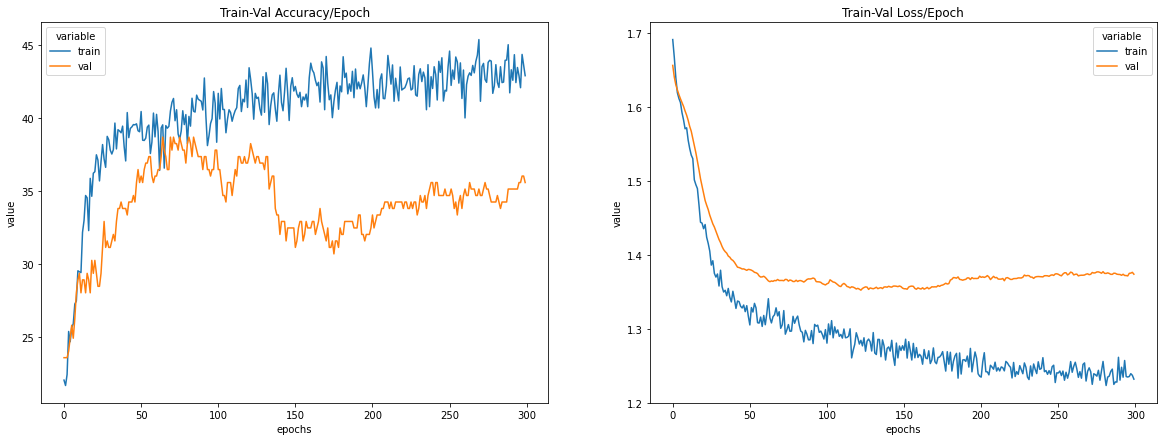

In [403]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [408]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [417]:
probs = predict(model, test_loader)
submit = pd.DataFrame({'y': np.argmax(probs, axis=1)})
submit

,y
0,4
1,0
2,4
3,2
4,1
...,...
370,4
371,2
372,1
373,2


In [418]:
submit.to_csv('synth.csv', index=False)